In [ ]:
!pip install -U transformers

## Local Inference on GPU
Model page: https://huggingface.co/sesame/csm-1b

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/sesame/csm-1b)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

The model you are trying to use is gated. Please make sure you have access to it by visiting the model page.To run inference, either set HF_TOKEN in your environment variables/ Secrets or run the following cell to login. 🤗

In [ ]:
from huggingface_hub import login
login(new_session=False)

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-to-speech", model="sesame/csm-1b")

In [1]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForTextToWaveform

tokenizer = AutoTokenizer.from_pretrained("sesame/csm-1b")
model = AutoModelForTextToWaveform.from_pretrained("sesame/csm-1b")

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/449 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.28k [00:00<?, ?B/s]

transformers.safetensors.index.json:   0%|          | 0.00/59.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

transformers-00001-of-00002.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

transformers-00002-of-00002.safetensors:   0%|          | 0.00/2.19G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/264 [00:00<?, ?B/s]

In [2]:
print(model)

CsmForConditionalGeneration(
  (lm_head): Linear(in_features=2048, out_features=2051, bias=False)
  (embed_text_tokens): Embedding(128256, 2048)
  (backbone_model): CsmBackboneModel(
    (embed_tokens): CsmBackboneModelEmbeddings(
      (embed_audio_tokens): Embedding(65632, 2048)
    )
    (layers): ModuleList(
      (0-15): 16 x CsmDecoderLayer(
        (self_attn): CsmAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): CsmMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        

Running on cuda
Model Initialized with 4 Quantization Layers.
Epoch 1 | Loss: 0.8563 | Recon: 0.0434 | VQ: 0.8129 | Perplexity: 169.9
Epoch 2 | Loss: 0.0383 | Recon: 0.0167 | VQ: 0.0216 | Perplexity: 273.1
Epoch 3 | Loss: 0.0283 | Recon: 0.0127 | VQ: 0.0156 | Perplexity: 266.0
Epoch 4 | Loss: 0.0234 | Recon: 0.0095 | VQ: 0.0139 | Perplexity: 266.7
Epoch 5 | Loss: 0.0205 | Recon: 0.0078 | VQ: 0.0127 | Perplexity: 269.7
Epoch 6 | Loss: 0.0185 | Recon: 0.0070 | VQ: 0.0115 | Perplexity: 272.4
Epoch 7 | Loss: 0.0174 | Recon: 0.0064 | VQ: 0.0109 | Perplexity: 278.7
Epoch 8 | Loss: 0.0167 | Recon: 0.0058 | VQ: 0.0109 | Perplexity: 286.4
Epoch 9 | Loss: 0.0166 | Recon: 0.0055 | VQ: 0.0112 | Perplexity: 294.8
Epoch 10 | Loss: 0.0167 | Recon: 0.0052 | VQ: 0.0115 | Perplexity: 300.7
Epoch 11 | Loss: 0.0163 | Recon: 0.0048 | VQ: 0.0115 | Perplexity: 306.1
Epoch 12 | Loss: 0.0167 | Recon: 0.0047 | VQ: 0.0120 | Perplexity: 310.4
Epoch 13 | Loss: 0.0168 | Recon: 0.0045 | VQ: 0.0123 | Perplexity: 316.

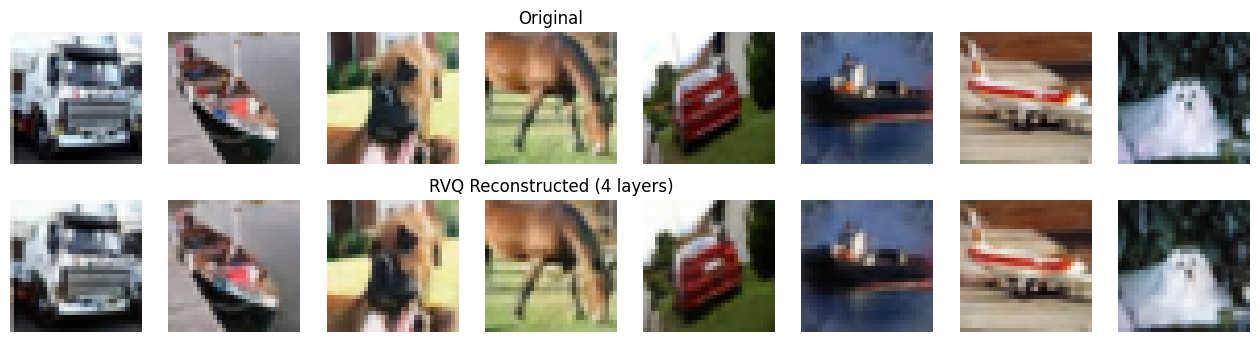

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# CONFIGURATION
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100

# RVQ Settings
NUM_RVQ_LAYERS = 4      # How many codebooks to stack? (The "Cascade")
NUM_EMBEDDINGS = 512    # Vocabulary size per codebook
EMBEDDING_DIM = 64      # Vector dimension
COMMITMENT_COST = 0.25  # Beta

print(f"Running on {DEVICE}")

# ==========================================
# 1. HELPER MODULES (ResNet Blocks)
# ==========================================
class ResidualBlock(nn.Module):
    """
    Standard ResNet block: x + Conv(Relu(Conv(x)))
    FIX: Changed ReLU(True) to ReLU(inplace=False) to prevent gradient crash.
    """
    def __init__(self, in_channels, hidden_channels):
        super(ResidualBlock, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(inplace=False), # <--- CHANGED THIS (Was True)
            nn.Conv2d(in_channels, hidden_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=False), # <--- CHANGED THIS (Was True)
            nn.Conv2d(hidden_channels, in_channels, 1, bias=False),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self._block(x)

# ==========================================
# 2. SINGLE VECTOR QUANTIZER
# ==========================================
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        # The Codebook Matrix
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # inputs: [Batch, Channels, Height, Width]
        # Flatten for distance calculation
        input_shape = inputs.shape
        flat_input = inputs.permute(0, 2, 3, 1).contiguous().view(-1, self._embedding_dim)

        # Calculate distances: (a-b)^2 = a^2 + b^2 - 2ab
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Get Code Indices
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        # Create One-Hot
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize (Lookup)
        quantized = torch.matmul(encodings, self._embedding.weight)
        quantized = quantized.view(input_shape[0], input_shape[2], input_shape[3], input_shape[1])
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        # Loss Calculation
        # 1. Codebook Loss: Move embeddings toward encoder output
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        # 2. Commitment Loss: Move encoder output toward embeddings
        q_latent_loss = F.mse_loss(quantized, inputs.detach())

        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()

        # Calculate Perplexity (Metric to check usage)
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized, perplexity, encoding_indices

# ==========================================
# 3. RESIDUAL VQ MANAGER (The Cascade)
# ==========================================
class ResidualVQ(nn.Module):
    def __init__(self, num_quantizers, num_embeddings, embedding_dim, commitment_cost):
        super(ResidualVQ, self).__init__()

        # Create a LIST of independent quantizers
        self.layers = nn.ModuleList([
            VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
            for _ in range(num_quantizers)
        ])

    def forward(self, x):
        quantized_out = 0.0
        residual = x

        all_losses = 0.0
        mean_perplexity = 0.0
        all_indices = []

        # LOOP through the stack of codebooks
        for i, layer in enumerate(self.layers):
            # Quantize the CURRENT residual
            loss, z_q, perplexity, indices = layer(residual)

            # Accumulate the reconstruction
            quantized_out = quantized_out + z_q

            # Update the residual (Error = Previous Error - Quantized Error)
            residual = residual - z_q

            # Accumulate stats
            all_losses += loss
            mean_perplexity += perplexity
            all_indices.append(indices)

        mean_perplexity /= len(self.layers)

        return all_losses, quantized_out, mean_perplexity, all_indices

# ==========================================
# 4. ENCODER & DECODER (With ResNets)
# ==========================================
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, embedding_dim):
        super(Encoder, self).__init__()

        # Initial Convolution
        self._conv_1 = nn.Conv2d(in_channels, num_hiddens // 2, 4, 2, 1) # Downsample
        self._conv_2 = nn.Conv2d(num_hiddens // 2, num_hiddens, 4, 2, 1) # Downsample

        # Stack of Residual Blocks
        self._residual_stack = nn.Sequential(
            *[ResidualBlock(num_hiddens, num_residual_hiddens)
              for _ in range(num_residual_layers)]
        )

        # Pre-Quantization Convolution
        self._pre_vq_conv = nn.Conv2d(num_hiddens, embedding_dim, 1, 1)

    def forward(self, inputs):
        x = F.relu(self._conv_1(inputs))
        x = F.relu(self._conv_2(x))
        x = self._residual_stack(x)
        return self._pre_vq_conv(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, out_channels):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels, num_hiddens, 3, 1, 1)

        self._residual_stack = nn.Sequential(
            *[ResidualBlock(num_hiddens, num_residual_hiddens)
              for _ in range(num_residual_layers)]
        )

        # Upsampling layers (Transposed Conv)
        self._conv_trans_1 = nn.ConvTranspose2d(num_hiddens, num_hiddens // 2, 4, 2, 1)
        self._conv_trans_2 = nn.ConvTranspose2d(num_hiddens // 2, out_channels, 4, 2, 1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = self._residual_stack(x)
        x = F.relu(self._conv_trans_1(x))
        x = self._conv_trans_2(x) # No activation here, handled by loss function or Tanh
        return torch.tanh(x)

# ==========================================
# 5. FULL MODEL WRAPPER
# ==========================================
class RVQVAE(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, num_rvq_layers):
        super(RVQVAE, self).__init__()

        self.encoder = Encoder(3, num_hiddens, num_residual_layers, num_residual_hiddens, embedding_dim)

        self.rvq = ResidualVQ(num_rvq_layers, num_embeddings, embedding_dim, commitment_cost)

        self.decoder = Decoder(embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens, 3)

    def forward(self, x):
        z = self.encoder(x)

        # Pass through the Cascade of Quantizers
        vq_loss, quantized, perplexity, _ = self.rvq(z)

        x_recon = self.decoder(quantized)

        return vq_loss, x_recon, perplexity

# ==========================================
# 6. TRAINING LOOP
# ==========================================
# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model Init
# num_hiddens=128: How thick the ResNets are
# num_residual_layers=2: How deep the ResNets are
model = RVQVAE(128, 2, 32, NUM_EMBEDDINGS, EMBEDDING_DIM, COMMITMENT_COST, NUM_RVQ_LAYERS).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Model Initialized with {NUM_RVQ_LAYERS} Quantization Layers.")

loss_history = []

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_recon_loss = 0
    epoch_vq_loss = 0
    epoch_perp = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()

        # Forward
        vq_loss, data_recon, perplexity = model(data)

        # Reconstruction Loss
        recon_loss = F.mse_loss(data_recon, data)

        # Total Loss
        loss = recon_loss + vq_loss
        loss.backward()

        # Gradient Clipping (Optional but good for stability)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        epoch_loss += loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_vq_loss += vq_loss.item()
        epoch_perp += perplexity.item()

    # Logging
    avg_loss = epoch_loss / len(train_loader)
    avg_perp = epoch_perp / len(train_loader)
    loss_history.append(avg_loss)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Recon: {epoch_recon_loss/len(train_loader):.4f} | VQ: {epoch_vq_loss/len(train_loader):.4f} | Perplexity: {avg_perp:.1f}")

# ==========================================
# 7. VISUALIZATION
# ==========================================
model.eval()
with torch.no_grad():
    (test_images, _) = next(iter(train_loader))
    test_images = test_images[:8].to(DEVICE)
    _, reconstructions, _ = model(test_images)

    test_images = test_images.cpu()
    reconstructions = reconstructions.cpu()

    def unnorm(img): return np.clip(img * 0.5 + 0.5, 0, 1)

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(unnorm(test_images[i].permute(1, 2, 0)))
        axes[0, i].axis('off')
        if i == 3: axes[0, i].set_title("Original")

        axes[1, i].imshow(unnorm(reconstructions[i].permute(1, 2, 0)))
        axes[1, i].axis('off')
        if i == 3: axes[1, i].set_title(f"RVQ Reconstructed ({NUM_RVQ_LAYERS} layers)")

    plt.show()